In [1]:
from __future__ import print_function

import argparse
import datetime
import os
import random
import sys
import time
#from sdtw.dataset import load_ucr
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from distance_handler import get_distance_handler
from sklearn.metrics import roc_auc_score, average_precision_score

torch.manual_seed(0)
acc, std = {}, {}

In [2]:
## Build the Model
### all the inputs/outputs/weigts here should be torch.autograd.Variable !

import torch
print('PyTorch version', torch.__version__)
from torch.autograd import Variable
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
def squared_l2_distance(x1, x2):
    '''
    Input: two tensors of size [T, D]
    nn.MSEloss can not take gradient on x2. pairwise_distance takes the square root. 
    The distance is devided by the alignment length 
    '''
    return torch.mean(torch.sum((x1 - x2)**2, dim=-1))
#    return torch.sum((x1 - x2)**2)


class Net(nn.Module):
    def __init__(self, n_in, n_hiddens, activations):
        super(Net, self).__init__()
        assert len(n_hiddens) == len(activations)
        self.n_layers = len(n_hiddens)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_in, n_hiddens[0])])
        for (n_inp, n_hid) in zip(n_hiddens[:-1], n_hiddens[1:]):
            self.hidden_layers.append(nn.Linear(n_inp, n_hid))
        
        self.activations = []
        

        for a in activations:
            #self.activations += [getattr(F, a)]
            self.activations +=[getattr(torch, a)]
       
            
    
    def forward(self, x):
        '''
        x is of size [n_t, n_dim]
        '''
        output = x
        # This is for non-rnn only

        for i_l in range(self.n_layers):
            output = self.activations[i_l](self.hidden_layers[i_l](output))
            
        return output
    
class LSTM(nn.Module):
    def __init__(self, n_in, n_hiddens, activations):
        
        super(LSTM, self).__init__()
        assert n_hiddens == activations
        self.n_layers = n_hiddens
        self.lstm = nn.LSTM(n_in, n_in, num_layers=activations, batch_first=False, dropout=0.0)
        self.linear = nn.Linear(n_in, n_in)
        self.relu = nn.ReLU()
       
        
    
    def forward(self, x):
        '''
        x is of size [n_t, n_dim]
        '''
        _, (h_n, _) = self.lstm(x.unsqueeze(0))         
        output = self.relu(self.linear(h_n[-1]))
       
        return output
    
    
# class PackLSTMClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, linear_dim, dropout=0.0):
#         super(PackLSTMClassifier, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=False, dropout=dropout)
#         self.linear = nn.Linear(hidden_dim, linear_dim)
#         self.out = nn.Linear(linear_dim, 2)

#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=dropout)

#     def forward(self, x):
#         _, (h_n, _) = self.lstm(x)
#         linear = self.relu(self.linear(h_n[-1]))
#         out = self.out(self.dropout(linear))
#         return out
    
class SiameseNet(nn.Module):
    def __init__(self, net):
        super(SiameseNet, self).__init__()
        self.net = net
    
    def forward(self, x1, x2):
        output1 = self.net(x1)
        output2 = self.net(x2)
        loss = squared_l2_distance(output1, output2)
        return loss
    
    
class TripletNet(nn.Module):
    def __init__(self, net, margin=1):
        super(TripletNet, self).__init__()
        self.net = net
        self.margin = margin
    
    def forward(self, x1, x2, x1b, x3):
        output1 = self.net(x1)
        output2 = self.net(x2)
        output1b = self.net(x1b)
        output3 = self.net(x3)
     
        loss = self.margin + squared_l2_distance(output1, output2) - squared_l2_distance(output1b, output3)
        return F.relu(loss)


PyTorch version 1.4.0


In [3]:
import scipy.io as sio

# Data Handler
DATA_FOLDER = os.path.join('..', 'data')
RAW_DATA_FILE_PATTERN = os.path.join('{data_folder}', '{dataset}', '{dataset}.mat')
FOLD_FILE_PATTERN = os.path.join('{data_folder}', '{dataset}', '{dataset}-{fold}folds.mat')
kRawDataPattern = '%s/%s/%s.mat'
kFoldFilePattern = '%s/%s/%s-%dfolds.mat'

_TEST_PART_ONLY_ = False

class DataHandler(object):
    '''
    Attributes:
        dataset: dataset name (folder and input file name as well).
        nfolds: number of folds.
        raw_data_file: name of data file.
        fold_file: name of fold file.
        p: # of features/dimensions.
    '''
    
    def __init__(self, dataset, nfolds=5, data_folder=DATA_FOLDER):
        '''
        After __init__, self.p is not set.
        '''
        self.dataset = dataset
        self.nfolds = nfolds
        self.rawdata_file = RAW_DATA_FILE_PATTERN.format(data_folder=data_folder, dataset=dataset, fold=nfolds)
        self.fold_file = FOLD_FILE_PATTERN.format(data_folder=data_folder, dataset=dataset, fold=nfolds)
        self.p = -1
        print('Initialized data file {} and fold file {}'.format(self.rawdata_file, self.fold_file))
    
    def _normalize(self, data_raw):
        '''
        Args:
            data_raw: with size N * [T_i, D].
        Returns:
            data_ret: same size as data_raw, with 0-mean, 1-std.
        '''
        data_all = np.vstack(data_raw)
        data_mean = np.mean(data_all, axis=0)
        data_std = np.std(data_all, axis=0)
        data_std[data_std < 1e-7] = 1.0 # make sure data_std > 0
        data_ret = np.empty_like(data_raw, dtype=object)
        for i, data_i in enumerate(data_raw):
            data_ret[i] = np.asarray((data_i - data_mean) / data_std, dtype='float32');
        return data_ret
    
    def _index_by_list(self, l, l_idx):
        if _TEST_PART_ONLY_:
            return [l[idx] for idx in l_idx.nonzero()[0]][:100]
        return [l[idx] for idx in l_idx.nonzero()[0]]
    
    def _get_3_folds(self, l, I_train, I_valid, I_test):
        return (self._index_by_list(l, I_train),
                self._index_by_list(l, I_valid),
                self._index_by_list(l, I_test))
    
    def load_rawdata(self):
        '''
        In rawdata_file: 
            X: input, with size of N * [T_i, P]
            y: output, with size of N
            T: length of X, with size of N
        In fold_file: 
            folds: indexes, with size of nfolds * [# of samples in the fold],
                   of value: [1, nfolds].
                   TEST (i), VALID (i+1), TRAINs (rest).
        Output:
            X_folds_tensor: normalized inputs in torch.Tensor, 
                with size of [n_folds, 3, N] of torch.Tensor(size=[T_i, P])
            X_folds_nparray: The (underlying) data of X_folds_tensor
                with size of [n_folds, 3, N] of np.array(size=[T_i, P])
            y_folds: labels in np.array
                with size of [n_folds, 3] of np.array(size=[N, #class])
            Update self.p
        '''
        print('... loading raw data')
        data = sio.loadmat(self.rawdata_file)
        folds = sio.loadmat(self.fold_file)
        X_raw = data['X']   # data['X']: X=(N,1), X[i][0]=(T,P)
        while X_raw.shape[0] == 1:
            X_raw = X_raw[0]
        X = np.empty([X_raw.shape[0]], dtype=object)
        for i in range(X_raw.shape[0]):
            X[i] = X_raw[i];
            while X[i].shape[0] == 1:
                X[i] = X[i][0]
        self.p = X[0].shape[-1]
        y = data['y'].flatten()
        I = folds['folds'].flatten()

        X_normed = self._normalize(X)
        X_normed_tensor = [torch.from_numpy(x) for x in X_normed]
        X_folds_tensor, X_folds_nparray, y_folds = [], [], []
        for ff in range(self.nfolds):   # x \in [1, nfolds] for all x in I
            I_test = I == ff+1
            I_valid = I == ((ff+1)%self.nfolds + 1)
            I_train = np.logical_not(np.logical_or(I_test, I_valid))
            X_folds_tensor.append(self._get_3_folds(X_normed_tensor, I_train, I_valid, I_test))
            X_folds_nparray.append(self._get_3_folds(X_normed, I_train, I_valid, I_test))
            y_folds.append((y[I_train], y[I_valid], y[I_test]))
            if _TEST_PART_ONLY_:
                y_folds[-1] = tuple([yy[:100] for yy in y_folds[-1]])
        print('The shape of the first y_train is', y_folds[0][0].shape)
        return X_folds_tensor, X_folds_nparray, y_folds

In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import fbeta_score
from scipy import stats

## Evaluate Handler
def knn_accuracy(dist_matrix, y_true, y_ref, K=range(1,20,2)):
    assert(len(dist_matrix) == len(y_true))
    assert(len(dist_matrix[0]) == len(y_ref))
    sorted_id = np.argsort(dist_matrix)
    acc = np.zeros([len(dist_matrix), len(K)])
    for i_k, k in enumerate(K):
        w = 1 + 0.5 * np.power(0.5, range(k))
        y_k = y_ref[sorted_id[:,:k]]
        for i in range(len(dist_matrix)):
            acc[i][i_k] = np.argmax(np.bincount(y_k[i], w)) == y_true[i]
    return np.mean(acc, axis=0)

def knn_auc(dist_matrix, y_true, y_ref, K=range(1,20,2)):
    assert(len(dist_matrix) == len(y_true))
    assert(len(dist_matrix[0]) == len(y_ref))
    sorted_id = np.argsort(dist_matrix)
    acc = np.zeros([len(dist_matrix), len(K)])
    auc = np.zeros([len(K)])
    f1 = np.zeros([len(K)])
    ap = np.zeros([len(K)])
    for i_k, k in enumerate(K):
        w = 1 + 0.5 * np.power(0.5, range(k))
        y_k = y_ref[sorted_id[:,:k]]
        for i in range(len(dist_matrix)):
            acc[i][i_k] = np.argmax(np.bincount(y_k[i], w)) == y_true[i]
      
        auc[i_k] = roc_auc_score(y_true, np.mean(y_k,1))
        
        #mode_dat = stats.mode(y_k,axis=1)
        #f1[i_k] = fbeta_score(y_true,  np.squeeze(mode_dat[0]), beta=1.0)
        ap[i_k] = average_precision_score(y_true, np.mean(y_k,1), average='weighted')
    print('I am calculating auc!')
    return np.mean(acc, axis=0), auc, ap

class EvaluateHander(object):
    def __init__(self, distance_handler):
        self.distance_handler = distance_handler
        # evaluate range for KNN
        self.K_knn = range(1,20,2)
        
    def evaluate(self, test_dataset, train_dataset):
        # extract dataset
        test_set_x, test_set_y = test_dataset
        train_set_x, train_set_y = train_dataset
        n_train = len(train_set_x)
        n_test = len(test_set_x)
        # compute distance between validation and training
        dist_te_tr = np.empty([n_test, n_train], dtype=object)
        for i_te, x_te in enumerate(test_set_x):
            for i_tr, x_tr in enumerate(train_set_x):
                dist_te_tr[i_te][i_tr] = self.distance_handler.dist(x_te, x_tr)
        # evaluate KNN accuracy
        #this_knn_accs = knn_accuracy(dist_te_tr, test_set_y, train_set_y, self.K_knn)
        # auc
        #this_knn_auc = knn_auc(dist_te_tr, test_set_y, train_set_y, self.K_knn)
        
        this_knn_acc, this_knn_auc, this_knn_ap  = knn_auc(dist_te_tr, test_set_y, train_set_y, self.K_knn)
        #return (this_knn_acc, this_knn_auc, this_knn_ap)
        #return this_knn_acc
        return this_knn_acc
    
    def knn_accuracy(self, test_dataset, train_dataset):
        return self.evaluate(test_dataset, train_dataset)

In [5]:
class TrainingCheckpoint(object):
    '''
    Provide formatted string of all training statistics.
    '''
    def __init__(self, i_epoch, total_loss, siamese_loss, triplet_loss, n_largemargin, 
                 validation_losses=None):
        self.i_epoch = i_epoch
        self.total_loss = total_loss
        self.siamese_loss = siamese_loss
        self.triplet_loss = triplet_loss
        self.n_largemargin = n_largemargin
        self.validation_losses = validation_losses
        self.module_state_dict = None
        self.optimizer_state_dict = None
        
    def __str__(self):
        return 'Epoch: {}; loss {} = (sia){} + (tri){}; # LM: {}; Mean Val Loss: {}'.format(
            self.i_epoch, self.total_loss, self.siamese_loss, self.triplet_loss, 
            self.n_largemargin, np.mean(self.validation_losses))

    def __repr(self):
        return self.__str__()
    

In [6]:
## Learner
class TimeseriesMetricLearner(object):
    def __init__(self, datasets, distance_handler):
        # datasets
        self.datasets = datasets
        self.train_set_x_tensor, self.valid_set_x_tensor, self.test_set_x_tensor = self.datasets[0]
        self.train_set_x_nparray, self.valid_set_x_nparray, self.test_set_x_nparray = self.datasets[1]
        self.train_set_y, self.valid_set_y, self.test_set_y = self.datasets[2]
        self.n_train, self.n_valid, self.n_test = [len(x) for x in self.datasets[0]]
        
        # handlers
        self.distance_handler = distance_handler
        self.evaluate_handler = EvaluateHander(self.distance_handler)
        self.checkpoints_best = None
        
        # settings
        self.n_target = 3
        self.n_imposter = 10
        self.siamese_weight = 1. / self.n_imposter
        self.triplet_weight = 1.
        self.validation_frequency = 1  
        self.patience = 5
    
    def build_model(self, n_in, n_hiddens, activations=['sigmoid']):
        print('build the model...')
        if args.distance_type == 'ManhattanLSTM':
            self.network = LSTM(n_in, len(activations), len(activations))
        else:
            if n_hiddens is None or n_hiddens == 0:
                n_hiddens = [int(n_in*hid_dim) for _ in range(len(activations))]
            self.network = Net(n_in, n_hiddens, activations)

        self.siamese_network = SiameseNet(self.network)
        self.triplet_network = TripletNet(self.network)
    
    def get_triplet_indices(self, is_shuffle=True):
        triplets = []
        for i in range(len(self.targets)):
            for j in self.targets[i]:
                for k in self.imposters[i]:
                    triplets.append((i, j, k))
        if is_shuffle:
            random.shuffle(triplets)
        return triplets
    
    def train_on_triplet(self, x, target, xb, imposter, optimizer):
        optimizer.zero_grad()
        triplet_loss = self.triplet_network(x, target, xb, imposter)
        siamese_loss = self.siamese_network(x, target)
        loss = self.triplet_weight * triplet_loss + self.siamese_weight * siamese_loss
        loss.backward()
        optimizer.step()
        return loss.item(), siamese_loss.item(), triplet_loss.item()
    
    def test_on_triplet(self, x, target, xb, imposter):
        triplet_loss = self.triplet_network(x, target, xb, imposter)
        siamese_loss = self.siamese_network(x, target)          
        loss = self.triplet_weight * triplet_loss + self.siamese_weight * siamese_loss
        return loss.item(), siamese_loss.item(), triplet_loss.item()
    
    def reset_targets_and_imposters(self, dist_tr_tr=None):
        print('... reset target neighbors and imposters')
        #self.update_original_distance()
        dist_tr_tr = self.distance_handler.compute_dist_mtx(self.train_set_x_nparray)
        targets = np.zeros([self.n_train, self.n_targets], dtype=int)
        imposters = np.zeros([self.n_train, self.n_imposters], dtype=int)    
        for i in range(self.n_train):
            neighbors = np.argsort(dist_tr_tr[i])
            targets[i,:] = neighbors[self.train_set_y[neighbors] == self.train_set_y[i]][1:self.n_targets+1] #0 is itself
            imposters[i,:] = neighbors[self.train_set_y[neighbors] != self.train_set_y[i]][:self.n_imposters]
        self.targets = targets
        self.imposters = imposters
        return dist_tr_tr
    
    def update_checkpoint(self, checkpoint_this, module, optimizer):
        n_settings = len(checkpoint_this.validation_losses)
        cnt_updates = 0
        if self.checkpoints_best is None:
            checkpoint_this.module_state_dict = module.state_dict()
            checkpoint_this.optimizer_state_dict = optimizer.state_dict()
            self.checkpoints_best = [checkpoint_this] * n_settings
            cnt_updates = n_settings
        else:
            for i, cp in enumerate(self.checkpoints_best):
                if checkpoint_this.validation_losses[i] < cp.validation_losses[i]:
                    if checkpoint_this.module_state_dict is None:
                        checkpoint_this.module_state_dict = module.state_dict()
                        checkpoint_this.optimizer_state_dict = optimizer.state_dict()
                    self.checkpoints_best[i] = checkpoint_this
                    cnt_updates += 1
        print('update {} checkpoint at {}th epoch.'.format(cnt_updates, checkpoint_this.i_epoch))

    def train(self, n_iters, learning_rate=1e-3, reset_ti=True, verbose=0):
        print('train the model...')
        losses = {'total_loss': [], 'siamese_loss': [], 'triplet_loss': [], 'largemargin_cnt': []}
        start_time = time.time()
        optimizer = optim.Adam(self.network.parameters(), weight_decay=1e-4)
        cnt_no_updates = 0
        # TODO: add early-stopping / adaptive learning rate
        for i_iter in range(n_iters):
            print('{}th iteration begins...'.format(i_iter))
            losses_iter = [0.] * 3  # total_loss, siamese_loss, triplet_loss
            n_lm_iter = 0
            if i_iter > 0 and reset_ti:
                self.reset_targets_and_imposters() # by new dist
            for i_triplet, (i, j, k) in enumerate(self.get_triplet_indices()):
                if verbose and i_triplet % 1000 == 0:
                    print(i_triplet if i_triplet % 10000 == 0 else '.', end="")
                # i, j, k are x, target, imposter
                # Check if we can move the path sampler on GPU. CPU path sampling is faster than Python sampling.
                path_i1, path_j1 = self.distance_handler.path(self.train_set_x_nparray[i], self.train_set_x_nparray[j])
                path_i2, path_k2 = self.distance_handler.path(self.train_set_x_nparray[i], self.train_set_x_nparray[k])
                if verbose > 1 and i_triplet == 0:
                    print('1st:', i, j, path_i1, path_j1, end="")
                    print('2nd:', i, k, path_i2, path_k2, end="")
                losses_this = self.train_on_triplet(
                    Variable(self.train_set_x_tensor[i][torch.IntTensor(path_i1).long()]),
                    Variable(self.train_set_x_tensor[j][torch.IntTensor(path_j1).long()]),
                    Variable(self.train_set_x_tensor[i][torch.IntTensor(path_i2).long()]),
                    Variable(self.train_set_x_tensor[k][torch.IntTensor(path_k2).long()]),
                    optimizer)
                losses_iter = [l + l_this for l, l_this in zip(losses_iter, losses_this)]
                n_lm_iter += losses_this[-1] > 0. 
                
            print ('\nloss for {}th iteration is {}, {}, {}'.format(i_iter, *losses_iter))
            elapsed_time = time.time() - start_time
            print ('elapsed time from start is {}m'.format(elapsed_time / 60.))
            losses['total_loss'].append(losses_iter[0])
            losses['siamese_loss'].append(losses_iter[1])
            losses['triplet_loss'].append(losses_iter[2])
            losses['largemargin_cnt'].append(n_lm_iter)
            checkpoint_this = TrainingCheckpoint(i_iter, losses_iter[0], losses_iter[1], losses_iter[2], n_lm_iter)
            if i_iter % self.validation_frequency == 0:
                val_acc = self.compute_valid_knn_accuracy()
                #val_acc = self.compute_valid_knn_accuracy()[0]
                checkpoint_this.validation_losses = [1. - va for va in val_acc]
                updated = self.update_checkpoint(checkpoint_this, self.network, optimizer)
                cnt_no_updates = 0 if updated else cnt_no_updates + 1
                if cnt_no_updates > self.patience:
                    print('Early stopping at {}th iter'.format(i_iter))
                    break
                #self.compute_test_knn_accuracy()
        print('Optimization complete.')
        return losses
    
    def compute_train_loss(self):
        '''Calculate the (marge-largin) loss function
        '''
        losses = [0.] * 3
        start_time = time.time()
        for i_triplet, (i, j, k) in enumerate(self.get_triplet_indices(is_shuffle=False)):
            if self.verbose and i_triplet % 1000 == 0:
                print(i_triplet if i_triplet % 10000 == 0 else '.', end="")
            # i, j, k are x, target, imposter
            path_i1, path_j1 = self.distance_handler.path(self.train_set_x_nparray[i], self.train_set_x_nparray[j])
            path_i2, path_k2 = self.distance_handler.path(self.train_set_x_nparray[i], self.train_set_x_nparray[k])
            if self.verbose > 1 and i_triplet == 0:
                print('1st:', i, j, path_i1, path_j1)
                print('2nd:', i, k, path_i2, path_k2)
            losses_this = self.test_on_triplet(
                Variable(self.train_set_x_tensor[i][torch.IntTensor(path_i1).long()], volatile=True),
                Variable(self.train_set_x_tensor[j][torch.IntTensor(path_j1).long()], volatile=True),
                Variable(self.train_set_x_tensor[i][torch.IntTensor(path_i2).long()], volatile=True),
                Variable(self.train_set_x_tensor[k][torch.IntTensor(path_k2).long()], volatile=True))
            losses = [l + l_this for l, l_this in zip(losses, losses_this)]
        if self.verbose:
            print('One pass for training data loss takes {}m'.format((time.time()-start_time)/ 60.))
        print ('Loss in training set (all, siamese, triplet) is {}'.format(losses))  

    def compute_knn_accuracy(self, x_eval, y_eval, x_ref, y_ref):
        '''Calculate k-nn classification accuracy on the given input.
        '''
        start_time = time.time()
        inp_eval = [self.network(Variable(t, volatile=True)).data.numpy() for t in x_eval]
        inp_ref = [self.network(Variable(t, volatile=True)).data.numpy() for t in x_ref]
        dataset_eval = (inp_eval, y_eval)
        dataset_ref = (inp_ref, y_ref)
        if self.verbose:
            print('Evaluate {} data with {} refs for {}m'.format(len(y_eval), len(y_ref), (time.time()-start_time)/60.))
        #return self.evaluate_handler.knn_accuracy(dataset_eval, dataset_ref)
        return self.evaluate_handler.knn_accuracy(dataset_eval, dataset_ref)
        
    def compute_valid_knn_accuracy(self):
        ret = self.compute_knn_accuracy(
                x_eval=self.valid_set_x_tensor, y_eval=self.valid_set_y, 
                x_ref=self.train_set_x_tensor, y_ref=self.train_set_y)
        if self.verbose:
            print('K-nn acc. on valid dataset is {}'.format(ret))
        return ret
    
    def compute_test_knn_accuracy(self):
        ret = self.compute_knn_accuracy(
                x_eval=self.test_set_x_tensor, y_eval=self.test_set_y, 
                x_ref=self.train_set_x_tensor + self.valid_set_x_tensor, 
                y_ref=np.concatenate((self.train_set_y, self.valid_set_y)))
        if self.verbose:
            print('K-nn acc. on test dataset is {}'.format(ret))
        return ret
    
    def evaluate_every_setting(self):
        n_settings = len(self.checkpoints_best)
        test_accs = []
        for i, cp in enumerate(self.checkpoints_best):
            self.network.load_state_dict(cp.module_state_dict)
            test_accs.append(self.compute_test_knn_accuracy())
        test_accs_best = np.amax(test_accs, axis=0)
        test_accs_best_index = np.argmax(test_accs, axis=0)
        print('Best test accuracy:', test_accs_best)
        print('Best test accuracy index:', test_accs_best_index)
        return test_accs_best, test_accs_best_index
    
        ## TODO: add this 
        # evaluate again history best for each KNN setting
#         for i in xrange(len(self.best_statistics.best_parameters)):
#             if self.verbose:
#                 print 'In the best iteration of ', i, ': '
#             self.network.set_params(self.best_statistics.best_parameters[i])
#             test_this_accs = 1 - self.evaluate_handler.evaluate(test_dataset, trainvalid_dataset, self.theta)
#             test_best_accs = np.maximum(test_best_accs, test_this_accs)
#             if self.verbose:
#                 print 'this accuracy: ', test_this_accs
#                 print 'best accuracy: ', test_best_accs
#         print "Best test accruacy:", test_best_accs
#         return test_best_accs, self.best_statistics.best_parameters

starting time:  2021-05-24 22:17:02.981670
Namespace(activations='relu,sigmoid', data_filename='ucieeg-new', data_folder='../new_data', distance_type='EDISTkdeIS_C_32_48_10', f='~/.local/share/jupyter/runtime/kernel-361d1caf-f27e-4e25-b947-d615a441fc5d.json', hid_dim=1)
Initialized data file ../new_data/ucieeg-new/ucieeg-new.mat and fold file ../new_data/ucieeg-new/ucieeg-new-5folds.mat
... loading raw data
The shape of the first y_train is (360,)
Looking for  EDISTkdeIS_C_32_48_10
... reset target neighbors and imposters
... compute pairwise EDISTNewISkde_C_32_48_10 distance for 360 time series
0.........100.........200.........300.....EDISTNewISkde_C_32_48_10 ran for 2.9312370856602987m
build the model...
train the model...
0th iteration begins...
0.........10000
loss for 0th iteration is 3474.5541003607213, 10700.297798037529, 2404.5243033766747
elapsed time from start is 6.623614394664765m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.00536733865737915m
I am calculating auc!
K-nn acc. on valid dataset is [0.85       0.84166667 0.84166667 0.84166667 0.84166667 0.84166667
 0.84166667 0.84166667 0.85       0.85833333]
update 10 checkpoint at 0th epoch.
1th iteration begins...
0.........10000
loss for 1th iteration is 954.9483223920688, 6685.677611961961, 286.38054955005646
elapsed time from start is 16.155935589472453m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.00458074410756429m
I am calculating auc!
K-nn acc. on valid dataset is [0.9        0.90833333 0.90833333 0.90833333 0.90833333 0.90833333
 0.90833333 0.90833333 0.90833333 0.90833333]
update 10 checkpoint at 1th epoch.
2th iteration begins...
0.........10000
loss for 2th iteration is 651.2876811446622, 4966.744282040745, 154.61324459314346
elapsed time from start is 27.71545190413793m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.004720648129781087m
I am calculating auc!
K-nn acc. on valid dataset is [0.825      0.83333333 0.83333333 0.83333333 0.83333333 0.85
 0.85       0.85       0.85833333 0.85833333]
update 0 checkpoint at 2th epoch.
3th iteration begins...
0.........10000
loss for 3th iteration is 497.4852716475725, 3959.599110174924, 101.5253534913063
elapsed time from start is 36.40481632153193m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.00841350555419922m
I am calculating auc!
K-nn acc. on valid dataset is [0.9        0.9        0.90833333 0.90833333 0.90833333 0.90833333
 0.90833333 0.90833333 0.90833333 0.90833333]
update 0 checkpoint at 3th epoch.
4th iteration begins...
0.........10000
loss for 4th iteration is 431.43927248218097, 3337.58649135381, 97.68061774969101
elapsed time from start is 46.84982192516327m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.004589088757832845m
I am calculating auc!
K-nn acc. on valid dataset is [0.90833333 0.90833333 0.9        0.9        0.9        0.9
 0.9        0.9        0.9        0.9       ]
update 1 checkpoint at 4th epoch.
5th iteration begins...
0.........10000
loss for 5th iteration is 352.51797991548665, 2796.016230072826, 72.9163521528244
elapsed time from start is 56.45500467220942m
Evaluate 120 data with 360 refs for 0.0029245615005493164m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on valid dataset is [0.90833333 0.90833333 0.90833333 0.91666667 0.91666667 0.91666667
 0.91666667 0.91666667 0.91666667 0.91666667]
update 7 checkpoint at 5th epoch.
Early stopping at 5th iter
Optimization complete.


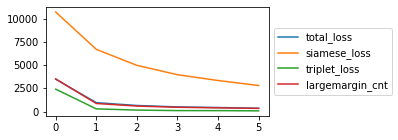

~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.0030437787373860676m
I am calculating auc!
K-nn acc. on test dataset is [0.95       0.94166667 0.925      0.90833333 0.93333333 0.93333333
 0.93333333 0.91666667 0.90833333 0.91666667]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.005414505799611409m
I am calculating auc!
K-nn acc. on test dataset is [0.925      0.93333333 0.91666667 0.90833333 0.90833333 0.90833333
 0.91666667 0.91666667 0.91666667 0.91666667]
Evaluate 120 data with 480 refs for 0.00289531946182251m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.93333333 0.94166667 0.925      0.90833333 0.93333333 0.925
 0.925      0.91666667 0.91666667 0.925     ]
Evaluate 120 data with 480 refs for 0.002896606922149658m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.94166667 0.925      0.93333333 0.91666667 0.925      0.90833333
 0.9        0.9        0.91666667 0.91666667]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.0039525628089904785m
I am calculating auc!
K-nn acc. on test dataset is [0.91666667 0.95       0.93333333 0.94166667 0.925      0.925
 0.9        0.90833333 0.90833333 0.91666667]
Evaluate 120 data with 480 refs for 0.0030571818351745605m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.94166667 0.93333333 0.93333333 0.925      0.925      0.91666667
 0.89166667 0.90833333 0.91666667 0.925     ]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.003859221935272217m
I am calculating auc!
K-nn acc. on test dataset is [0.94166667 0.93333333 0.94166667 0.90833333 0.91666667 0.91666667
 0.89166667 0.90833333 0.90833333 0.91666667]
Evaluate 120 data with 480 refs for 0.0030463616053263347m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.94166667 0.925      0.93333333 0.91666667 0.925      0.90833333
 0.925      0.9        0.91666667 0.91666667]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.008880722522735595m
I am calculating auc!
K-nn acc. on test dataset is [0.91666667 0.925      0.925      0.93333333 0.91666667 0.9
 0.925      0.93333333 0.9        0.90833333]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.003839592138926188m
I am calculating auc!
K-nn acc. on test dataset is [0.94166667 0.925      0.91666667 0.925      0.91666667 0.9
 0.89166667 0.90833333 0.91666667 0.90833333]
Best test accuracy: [0.95       0.95       0.94166667 0.94166667 0.93333333 0.93333333
 0.93333333 0.93333333 0.91666667 0.925     ]
Best test accuracy index: [0 4 6 4 0 0 0 8 1 2]
Calculating distance matrices...


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


... reset target neighbors and imposters
... compute pairwise EDISTNewISkde_C_32_48_10 distance for 360 time series
0.........100.........200.........300.....EDISTNewISkde_C_32_48_10 ran for 3.0009048779805503m
build the model...
train the model...
0th iteration begins...
0.........10000
loss for 0th iteration is 3489.0839159684256, 10442.30410054326, 2444.8534918427467
elapsed time from start is 5.076196440060934m
Evaluate 120 data with 360 refs for 0.002996218204498291m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on valid dataset is [0.85833333 0.86666667 0.85833333 0.84166667 0.85833333 0.85833333
 0.85833333 0.85833333 0.85833333 0.85833333]
update 10 checkpoint at 0th epoch.
1th iteration begins...
0.........10000
loss for 1th iteration is 910.442478980869, 6468.39403912425, 263.6030638217926
elapsed time from start is 13.049594740072886m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.00396268367767334m
I am calculating auc!
K-nn acc. on valid dataset is [0.88333333 0.89166667 0.88333333 0.88333333 0.88333333 0.88333333
 0.88333333 0.88333333 0.89166667 0.89166667]
update 10 checkpoint at 1th epoch.
2th iteration begins...
0.........10000
loss for 2th iteration is 599.3603863781318, 4718.126480422914, 127.54773008823395
elapsed time from start is 20.07773228486379m
Evaluate 120 data with 360 refs for 0.0033122142155965167m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on valid dataset is [0.83333333 0.83333333 0.825      0.83333333 0.85       0.84166667
 0.84166667 0.85       0.85       0.85      ]
update 0 checkpoint at 2th epoch.
3th iteration begins...
0.........10000
loss for 3th iteration is 479.5245457473211, 3749.712304510176, 104.55330872535706
elapsed time from start is 27.544761951764425m
Evaluate 120 data with 360 refs for 0.0030012607574462892m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on valid dataset is [0.875      0.89166667 0.875      0.875      0.875      0.875
 0.875      0.875      0.875      0.875     ]
update 0 checkpoint at 3th epoch.
4th iteration begins...
0.........10000
loss for 4th iteration is 365.99487731186673, 2923.039201900363, 73.69095224142075
elapsed time from start is 35.403063980738324m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.0045261422793070475m
I am calculating auc!
K-nn acc. on valid dataset is [0.89166667 0.89166667 0.89166667 0.89166667 0.89166667 0.89166667
 0.89166667 0.89166667 0.89166667 0.89166667]
update 7 checkpoint at 4th epoch.
5th iteration begins...
0.........10000
loss for 5th iteration is 301.3492075968534, 2474.5930733252317, 53.88989585638046
elapsed time from start is 44.03343985478083m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.004148177305857341m
I am calculating auc!
K-nn acc. on valid dataset is [0.90833333 0.90833333 0.90833333 0.91666667 0.91666667 0.9
 0.9        0.9        0.9        0.9       ]
update 10 checkpoint at 5th epoch.
Early stopping at 5th iter
Optimization complete.


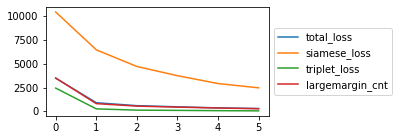

~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.0038605531056722007m
I am calculating auc!
K-nn acc. on test dataset is [0.925      0.90833333 0.91666667 0.91666667 0.90833333 0.9
 0.9        0.91666667 0.90833333 0.91666667]
Evaluate 120 data with 480 refs for 0.0028949975967407227m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.94166667 0.90833333 0.925      0.91666667 0.90833333 0.90833333
 0.90833333 0.90833333 0.90833333 0.90833333]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.0040681719779968265m
I am calculating auc!
K-nn acc. on test dataset is [0.925      0.91666667 0.91666667 0.90833333 0.90833333 0.90833333
 0.91666667 0.90833333 0.91666667 0.90833333]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.0038214524586995444m
I am calculating auc!
K-nn acc. on test dataset is [0.93333333 0.91666667 0.91666667 0.925      0.91666667 0.925
 0.91666667 0.91666667 0.91666667 0.90833333]
Evaluate 120 data with 480 refs for 0.0029063860575358072m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.90833333 0.91666667 0.90833333 0.90833333 0.91666667 0.90833333
 0.90833333 0.90833333 0.90833333 0.90833333]
Evaluate 120 data with 480 refs for 0.003052373727162679m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.93333333 0.925      0.90833333 0.91666667 0.91666667 0.90833333
 0.90833333 0.90833333 0.90833333 0.91666667]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.0038414756457010907m
I am calculating auc!
K-nn acc. on test dataset is [0.9        0.925      0.9        0.91666667 0.9        0.90833333
 0.90833333 0.90833333 0.90833333 0.90833333]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.00413287878036499m
I am calculating auc!
K-nn acc. on test dataset is [0.925      0.90833333 0.9        0.91666667 0.91666667 0.9
 0.91666667 0.91666667 0.90833333 0.90833333]
Evaluate 120 data with 480 refs for 0.002892426649729411m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.91666667 0.91666667 0.9        0.91666667 0.91666667 0.9
 0.9        0.9        0.9        0.90833333]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.005932307243347168m
I am calculating auc!
K-nn acc. on test dataset is [0.91666667 0.90833333 0.90833333 0.91666667 0.91666667 0.91666667
 0.90833333 0.90833333 0.91666667 0.91666667]
Best test accuracy: [0.94166667 0.925      0.925      0.925      0.91666667 0.925
 0.91666667 0.91666667 0.91666667 0.91666667]
Best test accuracy index: [1 5 1 3 3 3 2 0 2 0]
Calculating distance matrices...


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


... reset target neighbors and imposters
... compute pairwise EDISTNewISkde_C_32_48_10 distance for 360 time series
0.........100.........200.........300.....EDISTNewISkde_C_32_48_10 ran for 6.37591673930486m
build the model...
train the model...
0th iteration begins...
0.........10000
loss for 0th iteration is 3988.8241600822657, 10562.387202873826, 2932.5854256153107
elapsed time from start is 5.522549553712209m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.005370207627614339m
I am calculating auc!
K-nn acc. on valid dataset is [0.86666667 0.85       0.85       0.85       0.85833333 0.85833333
 0.85833333 0.85833333 0.85833333 0.85833333]
update 10 checkpoint at 0th epoch.
1th iteration begins...
0.........10000
loss for 1th iteration is 984.4933762527071, 6830.193997308612, 301.47396445274353
elapsed time from start is 16.127663290500642m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.004383305708567302m
I am calculating auc!
K-nn acc. on valid dataset is [0.9        0.90833333 0.91666667 0.90833333 0.90833333 0.90833333
 0.90833333 0.90833333 0.90833333 0.90833333]
update 10 checkpoint at 1th epoch.
2th iteration begins...
0.........10000
loss for 2th iteration is 639.823539851699, 4936.240969572216, 146.1994345188141
elapsed time from start is 26.868852853775024m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.0053092241287231445m
I am calculating auc!
K-nn acc. on valid dataset is [0.925      0.91666667 0.91666667 0.91666667 0.91666667 0.91666667
 0.91666667 0.91666667 0.91666667 0.91666667]
update 9 checkpoint at 2th epoch.
3th iteration begins...
0.........10000
loss for 3th iteration is 485.9552866644226, 3797.733292758465, 106.18195098638535
elapsed time from start is 34.08904358943303m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.003897873560587565m
I am calculating auc!
K-nn acc. on valid dataset is [0.85       0.86666667 0.86666667 0.86666667 0.86666667 0.86666667
 0.86666667 0.86666667 0.86666667 0.86666667]
update 0 checkpoint at 3th epoch.
4th iteration begins...
0.........10000
loss for 4th iteration is 394.033781836275, 3133.965995259583, 80.6371768116951
elapsed time from start is 40.718049530188246m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.0037904858589172365m
I am calculating auc!
K-nn acc. on valid dataset is [0.95       0.94166667 0.94166667 0.94166667 0.94166667 0.94166667
 0.94166667 0.94166667 0.93333333 0.94166667]
update 10 checkpoint at 4th epoch.
5th iteration begins...
0.........10000
loss for 5th iteration is 334.77407447830774, 2594.928936449811, 75.2811763882637
elapsed time from start is 46.971739474932356m
Evaluate 120 data with 360 refs for 0.0029935240745544434m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on valid dataset is [0.96666667 0.96666667 0.96666667 0.96666667 0.96666667 0.96666667
 0.96666667 0.96666667 0.96666667 0.96666667]
update 10 checkpoint at 5th epoch.
Early stopping at 5th iter
Optimization complete.


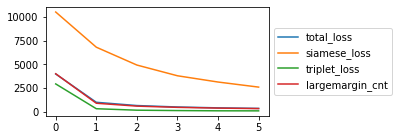

~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.0029165983200073243m
I am calculating auc!
K-nn acc. on test dataset is [0.9   0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925]
Evaluate 120 data with 480 refs for 0.0028429349263509114m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.875 0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925]
Evaluate 120 data with 480 refs for 0.0028464635213216144m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.91666667 0.91666667 0.925      0.925      0.925      0.925
 0.925      0.925      0.925      0.925     ]
Evaluate 120 data with 480 refs for 0.002871541182200114m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.9   0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.0034688313802083335m
I am calculating auc!
K-nn acc. on test dataset is [0.90833333 0.925      0.925      0.925      0.925      0.925
 0.925      0.925      0.925      0.925     ]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.003954192002614339m
I am calculating auc!
K-nn acc. on test dataset is [0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925]
Evaluate 120 data with 480 refs for 0.002825788656870524m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.89166667 0.925      0.925      0.925      0.925      0.925
 0.925      0.925      0.925      0.925     ]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.0038764476776123047m
I am calculating auc!
K-nn acc. on test dataset is [0.91666667 0.925      0.925      0.925      0.925      0.925
 0.925      0.925      0.925      0.925     ]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.005934719244639079m
I am calculating auc!
K-nn acc. on test dataset is [0.9   0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925]
Evaluate 120 data with 480 refs for 0.002836434046427409m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.90833333 0.925      0.925      0.925      0.925      0.925
 0.925      0.925      0.925      0.925     ]
Best test accuracy: [0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925 0.925]
Best test accuracy index: [5 0 0 0 0 0 0 0 0 0]
Calculating distance matrices...


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


... reset target neighbors and imposters
... compute pairwise EDISTNewISkde_C_32_48_10 distance for 360 time series
0.........100.........200.........300.....EDISTNewISkde_C_32_48_10 ran for 2.8729347904523213m
build the model...
train the model...
0th iteration begins...
0.........10000
loss for 0th iteration is 4139.422833909281, 10553.334034323692, 3084.0894165039062
elapsed time from start is 4.724883878231049m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.0038309097290039062m
I am calculating auc!
K-nn acc. on valid dataset is [0.925      0.925      0.925      0.91666667 0.925      0.91666667
 0.91666667 0.90833333 0.91666667 0.91666667]
update 10 checkpoint at 0th epoch.
1th iteration begins...
0.........10000
loss for 1th iteration is 986.846391836647, 6983.7399078682065, 288.4723891019821
elapsed time from start is 11.597074802716573m
Evaluate 120 data with 360 refs for 0.0030342499415079755m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on valid dataset is [0.94166667 0.94166667 0.94166667 0.93333333 0.93333333 0.93333333
 0.93333333 0.925      0.91666667 0.91666667]
update 8 checkpoint at 1th epoch.
2th iteration begins...
0.........10000
loss for 2th iteration is 624.3972741554026, 4797.491887778044, 144.6480768918991
elapsed time from start is 18.407804803053537m
Evaluate 120 data with 360 refs for 0.003054654598236084m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on valid dataset is [0.93333333 0.94166667 0.94166667 0.94166667 0.94166667 0.94166667
 0.94166667 0.94166667 0.94166667 0.94166667]
update 7 checkpoint at 2th epoch.
3th iteration begins...
0.........10000
loss for 3th iteration is 443.4947480543051, 3589.480542227626, 84.54668754339218
elapsed time from start is 25.49794842004776m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.005219034353892009m
I am calculating auc!
K-nn acc. on valid dataset is [0.95       0.95       0.93333333 0.93333333 0.93333333 0.93333333
 0.93333333 0.93333333 0.93333333 0.93333333]
update 2 checkpoint at 3th epoch.
4th iteration begins...
0.........10000
loss for 4th iteration is 382.7109938559588, 2977.5169883351773, 84.95928984880447
elapsed time from start is 33.92548792362213m
Evaluate 120 data with 360 refs for 0.0029469927151997886m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on valid dataset is [0.93333333 0.93333333 0.93333333 0.93333333 0.93333333 0.93333333
 0.93333333 0.94166667 0.94166667 0.93333333]
update 0 checkpoint at 4th epoch.
5th iteration begins...
0.........10000
loss for 5th iteration is 306.713215702679, 2529.0156473536044, 53.81164652109146
elapsed time from start is 42.87384361028671m
Evaluate 120 data with 360 refs for 0.0029805699984232583m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on valid dataset is [0.99166667 0.98333333 0.98333333 0.98333333 0.98333333 0.98333333
 0.98333333 0.98333333 0.98333333 0.98333333]
update 10 checkpoint at 5th epoch.
Early stopping at 5th iter
Optimization complete.


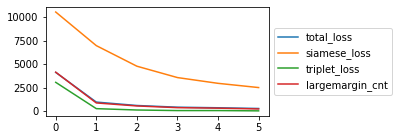

~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.003078571955362956m
I am calculating auc!
K-nn acc. on test dataset is [0.925      0.94166667 0.95       0.95       0.95       0.95
 0.95       0.95       0.95       0.95      ]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.003900738557179769m
I am calculating auc!
K-nn acc. on test dataset is [0.93333333 0.95       0.95       0.94166667 0.95833333 0.95833333
 0.95       0.94166667 0.94166667 0.93333333]
Evaluate 120 data with 480 refs for 0.0032121777534484864m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.925      0.95       0.94166667 0.94166667 0.95       0.95
 0.95       0.94166667 0.94166667 0.93333333]
Evaluate 120 data with 480 refs for 0.0028262972831726075m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.94166667 0.94166667 0.94166667 0.94166667 0.95       0.95
 0.95       0.94166667 0.93333333 0.94166667]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.006903823216756185m
I am calculating auc!
K-nn acc. on test dataset is [0.93333333 0.95       0.95       0.94166667 0.94166667 0.95
 0.94166667 0.94166667 0.94166667 0.94166667]
Evaluate 120 data with 480 refs for 0.002803770701090495m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.91666667 0.95       0.94166667 0.95       0.95       0.95
 0.95       0.95       0.94166667 0.94166667]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.0053207715352376304m
I am calculating auc!
K-nn acc. on test dataset is [0.91666667 0.95       0.94166667 0.94166667 0.95       0.95
 0.94166667 0.94166667 0.93333333 0.93333333]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.0038747111956278484m
I am calculating auc!
K-nn acc. on test dataset is [0.925      0.95       0.94166667 0.95       0.95       0.95833333
 0.94166667 0.94166667 0.94166667 0.94166667]
Evaluate 120 data with 480 refs for 0.003017282485961914m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.95       0.95       0.95       0.95       0.95833333 0.94166667
 0.95       0.94166667 0.94166667 0.94166667]


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.003866255283355713m
I am calculating auc!
K-nn acc. on test dataset is [0.91666667 0.94166667 0.95       0.95       0.95       0.95833333
 0.95       0.95       0.95       0.94166667]
Best test accuracy: [0.95       0.95       0.95       0.95       0.95833333 0.95833333
 0.95       0.95       0.95       0.95      ]
Best test accuracy index: [8 1 0 0 1 1 0 0 0 0]
Calculating distance matrices...


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


... reset target neighbors and imposters
... compute pairwise EDISTNewISkde_C_32_48_10 distance for 360 time series
0.........100.........200.........300.....EDISTNewISkde_C_32_48_10 ran for 2.8818436821301776m
build the model...
train the model...
0th iteration begins...
0.........10000
loss for 0th iteration is 4108.589781604707, 10837.315733239055, 3024.858192026615
elapsed time from start is 4.366536939144135m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.0037131190299987795m
I am calculating auc!
K-nn acc. on valid dataset is [0.90833333 0.90833333 0.9        0.9        0.90833333 0.90833333
 0.90833333 0.90833333 0.90833333 0.90833333]
update 10 checkpoint at 0th epoch.
1th iteration begins...
0.........10000
loss for 1th iteration is 984.5073534990661, 6879.9732215851545, 296.5100191831589
elapsed time from start is 11.059318709373475m
Evaluate 120 data with 360 refs for 0.0033177296320597333m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on valid dataset is [0.93333333 0.94166667 0.93333333 0.93333333 0.93333333 0.925
 0.925      0.93333333 0.94166667 0.94166667]
update 10 checkpoint at 1th epoch.
2th iteration begins...
0.........10000
loss for 2th iteration is 658.4737595478073, 5076.667773876339, 150.806973695755
elapsed time from start is 17.20689894358317m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.004061265786488851m
I am calculating auc!
K-nn acc. on valid dataset is [0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
update 0 checkpoint at 2th epoch.
3th iteration begins...
0.........10000
loss for 3th iteration is 492.51491318875924, 3863.06083548069, 106.20882284641266
elapsed time from start is 23.382101496060688m
Evaluate 120 data with 360 refs for 0.003081357479095459m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on valid dataset is [0.94166667 0.94166667 0.95       0.95       0.95       0.95
 0.95       0.94166667 0.95       0.95      ]
update 9 checkpoint at 3th epoch.
4th iteration begins...
0.........10000
loss for 4th iteration is 396.5697056709323, 3128.7202928997576, 83.69767099618912
elapsed time from start is 29.687347185611724m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 360 refs for 0.0037122686703999837m
I am calculating auc!
K-nn acc. on valid dataset is [0.93333333 0.93333333 0.93333333 0.93333333 0.93333333 0.93333333
 0.93333333 0.93333333 0.93333333 0.93333333]
update 0 checkpoint at 4th epoch.
5th iteration begins...
0.........10000
loss for 5th iteration is 338.3214383900631, 2602.567446861416, 78.06468945741653
elapsed time from start is 36.013408283392586m
Evaluate 120 data with 360 refs for 0.002946321169535319m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on valid dataset is [0.90833333 0.90833333 0.90833333 0.90833333 0.90833333 0.90833333
 0.90833333 0.90833333 0.90833333 0.90833333]
update 0 checkpoint at 5th epoch.
Early stopping at 5th iter
Optimization complete.


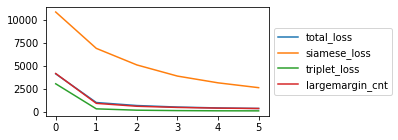

~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Evaluate 120 data with 480 refs for 0.00296858549118042m
I am calculating auc!
K-nn acc. on test dataset is [0.96666667 0.96666667 0.98333333 0.975      0.98333333 0.975
 0.975      0.975      0.98333333 0.98333333]
Evaluate 120 data with 480 refs for 0.0029227534929911294m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.96666667 0.975      0.975      0.975      0.975      0.975
 0.98333333 0.975      0.975      0.98333333]
Evaluate 120 data with 480 refs for 0.0028387983640034992m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.96666667 0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.975      0.975     ]
Evaluate 120 data with 480 refs for 0.0028571565945943195m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.96666667 0.975      0.975      0.975      0.975      0.975
 0.975      0.98333333 0.98333333 0.98333333]
Evaluate 120 data with 480 refs for 0.0028078277905782064m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.975      0.975      0.975      0.975      0.975      0.98333333
 0.975      0.975      0.975      0.975     ]
Evaluate 120 data with 480 refs for 0.0028591553370157876m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.96666667 0.975      0.975      0.98333333 0.98333333 0.98333333
 0.98333333 0.98333333 0.98333333 0.98333333]
Evaluate 120 data with 480 refs for 0.002868310610453288m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.96666667 0.975      0.975      0.98333333 0.98333333 0.975
 0.975      0.975      0.975      0.975     ]
Evaluate 120 data with 480 refs for 0.002891401449839274m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.96666667 0.975      0.975      0.975      0.975      0.975
 0.975      0.975      0.98333333 0.98333333]
Evaluate 120 data with 480 refs for 0.0028992295265197754m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.96666667 0.975      0.975      0.975      0.975      0.975
 0.975      0.98333333 0.98333333 0.98333333]
Evaluate 120 data with 480 refs for 0.0028378923734029135m


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:174: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:175: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


I am calculating auc!
K-nn acc. on test dataset is [0.96666667 0.975      0.975      0.975      0.98333333 0.98333333
 0.98333333 0.98333333 0.98333333 0.98333333]
Best test accuracy: [0.975      0.975      0.98333333 0.98333333 0.98333333 0.98333333
 0.98333333 0.98333333 0.98333333 0.98333333]
Best test accuracy index: [4 1 0 5 0 4 1 3 0 0]
Calculating distance matrices...


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Test accuracy (mean): [0.94833333 0.945      0.945      0.945      0.94333333 0.945
 0.94166667 0.94166667 0.93833333 0.94      ]
Test accuracy (std): [0.01615893 0.01870829 0.0214735  0.0214735  0.02438123 0.0227303
 0.02357023 0.02357023 0.02560382 0.02438123]


In [7]:
from sklearn import manifold  # multidimensional scaling

    
## main
if __name__ == '__main__':
    print('starting time: ', datetime.datetime.now())
    # set paths, etc.

    
    arg_parser = argparse.ArgumentParser()
    arg_parser.add_argument('-f', type=str, help='just a placeholder for jupyter notebook args -f. Not used.')
    arg_parser.add_argument('--data_folder', type=str, default=r'../new_data')
    #arg_parser.add_argument('--data_filename', type=str, default=r'ucieeg-down-binary')
    arg_parser.add_argument('--data_filename', type=str, default=r'ucieeg-new') # (3,10,1, 2)
    #arg_parser.add_argument('--data_filename', type=str, default=r'ucr-data-aspreg')
    #arg_parser.add_argument('--data_filename', type=str, default=r'ras-data-cdnd')
    #arg_parser.add_argument('--data_filename', type=str, default=r'physio-data')
    #arg_parser.add_argument('--data_filename', type=str, default=r'syn-data-100-20')
    
    #Physio-net
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTkdeIS_C_49_60_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTisNew_C_49_60_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTNew_C_49_60_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'DTW_C') #
    #arg_parser.add_argument('--distance_type', type=str, default=r'Manhattan') 
    #arg_parser.add_argument('--distance_type', type=str, default=r'soft-dtw')
    
    #RAS
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTisNew_C_5_400_10')
    #60_90 10 70, 60_90_10 5 71, 60_100_10 70 auc 1 60 200 5
    
    # EEG
    #arg_parser.add_argument('--distance_type', type=str, default=r'DTW_C') #
    arg_parser.add_argument('--distance_type', type=str, default=r'EDISTkdeIS_C_32_48_10')
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTNew_C_32_48_10')
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTisNew_C_32_48_10') #
    #arg_parser.add_argument('--distance_type', type=str, default=r'Manhattan') 
    
    #ASPREG
    #arg_parser.add_argument('--distance_type', type=str, default=r'DTW_C') #
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTisNew_C_350_400_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'Manhattan')  
    
    #Syn-data
    #arg_parser.add_argument('--distance_type', type=str, default=r'DTW_C') #
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTisNew_C_185_240_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTisNew_C_90_100_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'EDISTkdeIS_C_90_100_5')
    #arg_parser.add_argument('--distance_type', type=str, default=r'soft-dtw')
    #arg_parser.add_argument('--distance_type', type=str, default=r'ManhattanLSTM')
    #arg_parser.add_argument('--distance_type', type=str, default=r'ManhattanLSTM')
    
    arg_parser.add_argument('--activations', type=str, default=r'relu,sigmoid')
    #arg_parser.add_argument('--activations', type=str, default=r'')
    arg_parser.add_argument('--hid_dim', type=float, default=1)
    args = arg_parser.parse_args()
    print(args)
    
    data_folder = args.data_folder
    data_filename = args.data_filename
    distance_type = args.distance_type
    activations = args.activations.split(',') 
    hid_dim = args.hid_dim
    
    
            
    distTrTr = []
    distTeTr = []
    
    data_handler = DataHandler(dataset=data_filename, data_folder=data_folder)
    x_folds_tensor, x_folds_nparray, y_folds = data_handler.load_rawdata()
    distance_handler = get_distance_handler(distance_type)
    n_out = 0
    test_accs_all = []
    #for fold_id in range(0,1):
    for fold_id in range(data_handler.nfolds):
        datasets = (x_folds_tensor[fold_id], x_folds_nparray[fold_id], y_folds[fold_id])
        # train model
        learner = TimeseriesMetricLearner(datasets, distance_handler)
        learner.verbose = True
        # set learner parameters
        learner.n_targets = 3
        learner.n_imposters = 10
        learner.delta_ratio = 1
        learner.lambda_ratio = 2.
        # steps prepare for training
        learner.reset_targets_and_imposters()
        #learner.set_init_para_lambda()	# control the ratio of target and imposter in objective.
        learner.build_model(data_handler.p, n_hiddens=n_out, activations=activations)
        losses = learner.train(20, reset_ti=False, verbose=1)
        # plot and evaluate
        plt.figure(figsize=(4, 2))
        plot_lines = []
        plot_legends = losses.keys()
        for lk in plot_legends:
            line, = plt.plot(np.arange(len(losses[lk])), losses[lk])
            plot_lines.append(line)
        plt.legend(plot_lines, plot_legends, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()
        test_acc, _ = learner.evaluate_every_setting()
        test_accs_all.append(test_acc)

        print('Calculating distance matrices...')
        y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
        x_ref = [learner.network(Variable(t, volatile=True)).data.numpy() for t in learner.train_set_x_tensor + learner.valid_set_x_tensor]

        dist_tr_tr = np.empty([learner.n_train + learner.n_valid, learner.n_train + learner.n_valid], dtype = float);
        for i in range(len(y_ref)):
            for j in range(len(y_ref)):
                X1 = x_ref[i]
                X2 = x_ref[j]
        
                dist_tr_tr[i][j] = learner.distance_handler.dist(X1, X2)
        
        distTrTr.append(dist_tr_tr)



        dist_te_tr = np.empty([learner.n_test, learner.n_train+learner.n_valid], dtype=object)
        for i_te in range(learner.n_test):
            for i_tr in range(learner.n_train+learner.n_valid):
            
                X1 =learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_te])).detach().numpy() 
                X2 = x_ref[i_tr]
        
                dist_te_tr[i_te][i_tr] = learner.distance_handler.dist(X1, X2)
        
        distTeTr.append(dist_te_tr)

        
    print('Test accuracy (mean): {}\nTest accuracy (std): {}'.format(
            np.mean(test_accs_all, axis=0), np.std(test_accs_all, axis=0)))
        

       

In [10]:
#decade is 5 
print(np.mean(test_accs_all,0))
print(np.std(test_accs_all,0))

#decade 10
#Test accuracy (mean): [0.67411846 0.67141168 0.66689087 0.66779585 0.66509315 0.66058049
# 0.66329135 0.66599812 0.6651013  0.6651013 ]
#Test accuracy (std): [0.03341196 0.0348336  0.03889882 0.03772493 0.03427417 0.03510212
# 0.03612214 0.03627895 0.03453834 0.03547416]

[0.6570258  0.65884799 0.65794709 0.65974074 0.66064571 0.65974481
 0.65613713 0.65433125 0.65252945 0.65343035]
[0.02402996 0.02506496 0.02451895 0.02246213 0.02126807 0.02070015
 0.02442065 0.02430535 0.02295255 0.02374141]


In [8]:
print(np.mean(test_accs_all,0))
print(np.std(test_accs_all,0))

# DTW_C (syn)
# Test accuracy (mean): [0.87333333 0.905      0.92166667 0.925      0.93166667 0.945
#  0.95166667 0.95       0.95833333 0.95166667]
# Test accuracy (std): [0.02321398 0.0214735  0.02392117 0.02527625 0.02758824 0.0335824
#  0.03045944 0.02635231 0.02581989 0.02905933]

# DEcade
#Test accuracy (mean): [0.89833333 0.92666667 0.94166667 0.95       0.955      0.95833333
# 0.95666667 0.96       0.97       0.96666667]
#Test accuracy (std): [0.01433721 0.01615893 0.02108185 0.01900292 0.01943651 0.01581139
# 0.02       0.01615893 0.01545603 0.01394433]

#isea
#Test accuracy (mean): [0.89       0.92166667 0.93       0.94       0.95166667 0.95333333
# 0.95833333 0.96333333 0.95833333 0.96333333]
#Test accuracy (std): [0.0062361  0.01       0.01247219 0.00971825 0.01105542 0.00666667
# 0.01178511 0.01130388 0.01178511 0.01715938]



[0.65337736 0.67143207 0.66781623 0.66963434 0.66962211 0.66690718
 0.66961803 0.67232481 0.67052301 0.67141576]
[0.02949373 0.02443177 0.02797058 0.02278133 0.02779595 0.03197693
 0.02912946 0.03222107 0.0309507  0.03375236]


In [9]:
#decade is 10 
print(np.mean(test_accs_all,0))
print(np.std(test_accs_all,0))

[0.65430272 0.65790632 0.66242713 0.66152216 0.65972035 0.66152623
 0.65701357 0.65881538 0.66062533 0.6570095 ]
[0.01712664 0.02179518 0.01947752 0.02253739 0.02148953 0.02228732
 0.02155729 0.01976169 0.01900185 0.01924139]


In [14]:
#decade is 
Test accuracy (mean): [0.99666667 0.99666667 0.99833333 1.         1.         0.99833333
 0.99833333 1.         0.99833333 0.99833333]
Test accuracy (std): [0.00408248 0.00408248 0.00333333 0.         0.         0.00333333
 0.00333333 0.         0.00333333 0.00333333]



[0.93833333 0.935      0.93833333 0.935      0.935      0.93166667
 0.93333333 0.93       0.93       0.93166667]
[0.00849837 0.01224745 0.01247219 0.01105542 0.01224745 0.01333333
 0.00912871 0.01       0.00666667 0.0062361 ]


In [8]:
from scipy.io import savemat
acc_mean = np.mean(test_accs_all, axis=0)
acc_std =  np.std(test_accs_all, axis=0)
mdic = {"distTrTr": distTrTr, "distTeTr": distTeTr, 'acc_mean': acc_mean, 'acc_std' : acc_std, 'acc': test_accs_all }
#out_dir = '../python_pytorch/results/syn-data-100-15/run_jupyter/'
#out_dir = '../python_pytorch/results/NeurIPS2021/physio-data/run_jupyter/'
out_dir = '../python_pytorch/results/NeurIPS2021/uci-eeg/run_jupyter/'
#out_dir = '../python_pytorch/results/NeurIPS2021/syn-data-100-20/run_jupyter/'
savemat(out_dir + distance_type + '_hid_' +str(hid_dim) + "updated_res.mat", mdic)

In [8]:
# from scipy.io import loadmat
# res = loadmat(out_dir + distance_type + "_res.mat")
distance_type

'ManhattanLSTM'

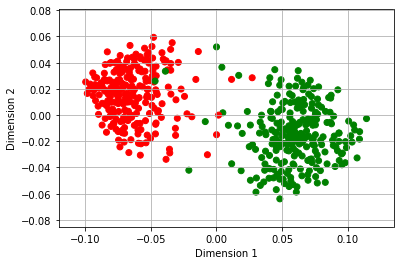

In [9]:
dist_tr_tr = distTrTr[4]
y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
dist_mat = dist_tr_tr*0.5 + dist_tr_tr.T*0.5
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
#mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
#manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
mds_fit = mds_model.fit(dist_mat)  
mds_coords = mds_model.fit_transform(dist_mat) 
color= ['red' if l == 0 else 'green' for l in y_ref]
#color= ['red' if l == 0 else 'green' for l in learner.test_set_y]
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
plt.grid()
plt.axis('tight')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
#plt.savefig('../python_pytorch/results/NeurIPS2021/syn-data-100-20/run_jupyter/syn-data-100-20-MaLSTM-embedding.png', bbox_inches='tight')
plt.savefig('../python_pytorch/results/NeurIPS2021/uci-eeg/run_jupyter/uci-eeg-ISEA-KDE-updated-embedding.png', bbox_inches='tight')
#plt.savefig('../python_pytorch/results/NeurIPS2021/physio-data/run_jupyter/physio-data-ISEA-KDE-10-embedding.png', bbox_inches='tight')

plt.show()

In [20]:
x_eval=learner.test_set_x_tensor 
y_eval=learner.test_set_y
x_ref=learner.train_set_x_tensor + learner.valid_set_x_tensor
y_ref=np.concatenate((learner.train_set_y, learner.valid_set_y))

inp_eval = [learner.network(Variable(t, volatile=True)).data.numpy() for t in x_eval]
inp_ref = [learner.network(Variable(t, volatile=True)).data.numpy() for t in x_ref]
test_dataset = (inp_eval, y_eval)
train_dataset = (inp_ref, y_ref)

# extract dataset
test_set_x, test_set_y = test_dataset
train_set_x, train_set_y = train_dataset
n_train = len(train_set_x)
n_test = len(test_set_x)
# compute distance between validation and training
dist_te_tr = np.empty([n_test, n_train], dtype=object)
for i_te, x_te in enumerate(test_set_x):
    for i_tr, x_tr in enumerate(train_set_x):
        dist_te_tr[i_te][i_tr] = learner.distance_handler.dist(x_te, x_tr)

k = 9
sorted_id = np.argsort(dist_te_tr)
y_k = y_ref[sorted_id[:,:k]]
mode_dat = stats.mode(y_k, axis=1)        
y_pred = np.squeeze(mode_dat[0])


~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys


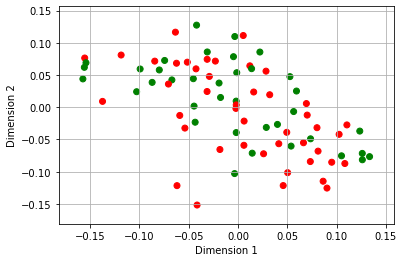

In [14]:
n_test = learner.n_test
y_eval=learner.test_set_y
dist_te_te = np.empty([n_test, n_test], dtype=object)
for i_te in range(learner.n_test):
    for i_tr in range(learner.n_test):
        #X1 = learner.test_set_x_nparray[i_te]
        #X2 = learner.test_set_x_nparray[i_tr]
        
        X1 = learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_te])).detach().numpy()
        X2 = learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_tr])).detach().numpy()
  
        dist_te_te[i_te][i_tr] = learner.distance_handler.dist(X1, X2)

dist_mat = dist_te_te*0.5 + dist_te_te.T*0.5
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
#mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
#manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
mds_fit = mds_model.fit(dist_mat)  
mds_coords = mds_model.fit_transform(dist_mat) 
color= ['red' if l == 0 else 'green' for l in y_eval]
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
plt.grid()
plt.axis('tight')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
#plt.savefig('../python_pytorch/results/ras-entry-angle/isdecade-before-rep-auc.png', bbox_inches='tight')
#plt.savefig('../python_pytorch/results/eeg/MaLSTM__after_test.png', bbox_inches='tight')

plt.show()

In [39]:
# evaluate KNN accuracy
#sorted_id = np.argsort(dist_te_tr)
#y_k = train_set_y[sorted_id[:,:k]]
from sklearn.metrics import balanced_accuracy_score

def knn_auc(dist_matrix, y_true, y_ref, K=range(1,20,2)):
 
    sorted_id = np.argsort(dist_matrix)
    acc = np.zeros([len(dist_matrix), len(K)])
    auc = np.zeros([len(K)])
    bal_acc = np.zeros([len(K)])
    f1 = np.zeros([len(K)])
    for i_k, k in enumerate(K):
        w = 1 + 0.5 * np.power(0.5, range(k))
        y_k = y_ref[sorted_id[:,:k]]
        y_pred = []
        for i in range(len(dist_matrix)):
            acc[i][i_k] = np.argmax(np.bincount(y_k[i], w)) == y_true[i]
            y_pred.append(np.argmax(np.bincount(y_k[i], w)))
        bal_acc[i_k] = balanced_accuracy_score(y_true, y_pred)
        
    
        mode_dat = stats.mode(y_k,axis=1)
      
        f1[i_k] = fbeta_score(y_true,  np.squeeze(mode_dat[0]), beta=1.0)
      

        auc[i_k] = roc_auc_score(y_true, np.mean(y_k,1))
    print('I am calculating aucs!')
    print(y_true.shape)
    print(y_ref.shape)
    print(np.mean(y_k,1).shape)
        
    print('I am calculating aucs!')
    return np.mean(acc, axis=0), bal_acc

# auc
this_knn_auc, this_bal_acc = knn_auc(dist_te_tr, test_set_y, train_set_y)





 #       return self.evaluate_handler.knn_accuracy(dataset_eval, dataset_ref)
        

I am calculating aucs!
(81,)
(325,)
(81,)
I am calculating aucs!


In [41]:
print(this_bal_acc)
print(this_knn_auc)

[0.43427518 0.48402948 0.52027027 0.55159705 0.54944717 0.54944717
 0.54944717 0.54944717 0.54944717 0.54944717]
[0.43209877 0.48148148 0.51851852 0.54320988 0.54320988 0.54320988
 0.54320988 0.54320988 0.54320988 0.54320988]


In [56]:
sorted_id = np.argsort(dist_te_tr)
y_k = train_set_y[sorted_id[:,:20]]
y_k.shape

(160, 20)

In [86]:
from sklearn.metrics import average_precision_score, confusion_matrix, balanced_accuracy_score
k = 4
mode_dat = stats.mode(y_k[:,:k], axis=1)
acc = np.mean(np.squeeze(mode_dat[0]) == y_eval)
f1 = fbeta_score(y_eval,  np.squeeze(mode_dat[0]), beta=1)
auc = roc_auc_score(y_eval, np.mean(y_k[:,:k],1))

c_m = confusion_matrix(y_eval,  np.squeeze(mode_dat[0]))
ba = balanced_accuracy_score(y_eval, np.squeeze(mode_dat[0]))
print(acc, f1, auc, ap, ba)
print(c_m)

0.8 0.2 0.6294424019607843 0.21582602339181284 0.5392156862745098
[[124  12]
 [ 20   4]]


24

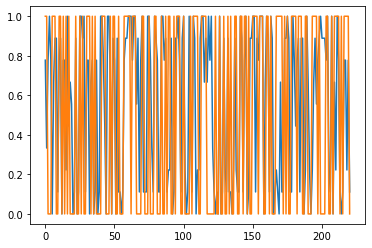

In [13]:
plt.plot(np.mean(y_k[:,:k],1))
plt.plot(y_eval)

In [42]:
mode_dat = stats.mode(y_k,axis=1)
np.squeeze(mode_dat[0]).shape

(160,)

In [47]:

roc_auc_score(y_eval, np.mean(y_k,1))
mode_dat = stats.mode(y_k,axis=1)
f1 = fbeta_score(y_eval,  np.squeeze(mode_dat[0]), beta=1)


0.1904761904761905

In [55]:
this_knn_auc

array([0.8   , 0.8   , 0.7875, 0.7875, 0.7875, 0.7875, 0.7875, 0.7875,
       0.7875, 0.7875])

In [8]:
# something to think of:

# Keep the same targets, but only update imposters (or also keep it. Originally all imposters are considered)
# Change the value of margin
# Think of how the to change the learning rate
# Plot: valid losses, valid/test knn, etc.

In [10]:
from sklearn import manifold  # multidimensional scaling

# visualize learnt representations
dist_tr_tr = np.empty([learner.n_train, learner.n_train], dtype = float);
for i in range(learner.n_train):
        for j in range(learner.n_train):
            #X1 = learner.network.forward(torch.from_numpy(learner.train_set_x_nparray[i])).detach().numpy()
            #X2 = learner.network.forward(torch.from_numpy(learner.train_set_x_nparray[j])).detach().numpy()
            X1 = learner.train_set_x_nparray[i]
            X2 = learner.train_set_x_nparray[j]

            #dist_tr_tr[i][j], _ _ = learner.distance_handler.dist_and_path(X1, X2)
            dist_tr_tr[i][j] = learner.distance_handler.dist(X1, X2)
            #print(Variable(learner.train_set_x_tensor[i][torch.IntTensor(path_i1).long()]).shape)
            #print(Variable(learner.train_set_x_tensor[j][torch.IntTensor(path_j1).long()]).shape)
            #break


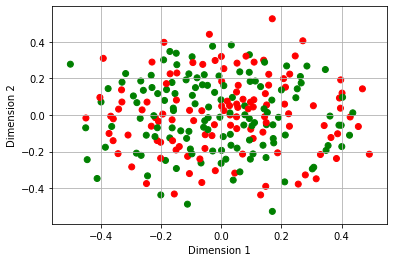

In [11]:
dist_mat = dist_tr_tr*0.5 + dist_tr_tr.T*0.5
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
#mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
#manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
mds_fit = mds_model.fit(dist_mat)  
mds_coords = mds_model.fit_transform(dist_mat) 
color= ['red' if l == 0 else 'green' for l in learner.train_set_y]
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
plt.grid()
plt.axis('tight')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
#plt.savefig('../python_pytorch/results/eeg/MaLSTM_32_48_10_3_10_1_2_half_before.png', bbox_inches='tight')
plt.show()

1


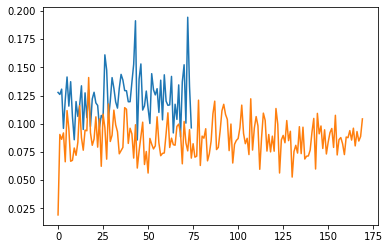

In [11]:
print(learner.train_set_y[0])
plt.plot(dist_tr_tr[0][learner.train_set_y==0])
plt.plot(dist_tr_tr[0][learner.train_set_y==1])
#plt.plot(learner.train_set_y*0.4)

In [70]:
X1 = learner.train_set_x_nparray[0]
X2 = learner.train_set_x_nparray[0]
d, _,_ = learner.distance_handler.dist_and_path(X1, X2)

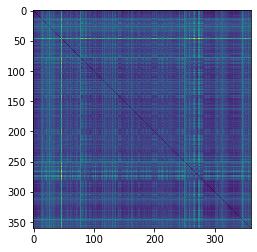

In [71]:
plt.imshow(dist_mat)

AttributeError: module 'matplotlib.pyplot' has no attribute 'zlabel'

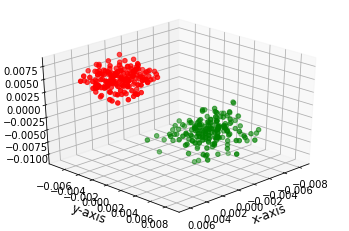

In [139]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mds_coords[:,0],mds_coords[:,1], mds_coords[:,2], color=color)
ax.view_init(30, 45)
plt.xlabel('x-axis', fontsize=12)
plt.ylabel('y-axis', fontsize=12)
plt.zlabel('z-axis', fontsize=14)
plt.show()


In [13]:
X2.shape

(32, 32)

In [23]:
k = 9
i = 1
w = 1 + 0.5 * np.power(0.5, range(k))
y_eval=learner.test_set_y
y_ref=np.concatenate((learner.train_set_y, learner.valid_set_y))
sorted_id = np.argsort(dist_te_tr)
y_k = y_ref[sorted_id[:,:k]]

In [75]:
out_dir = '../python_pytorch/results/ucieeg-new/run_jupyter/'

In [76]:
distance_type

'EDISTisNew_C_32_48_5'

~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


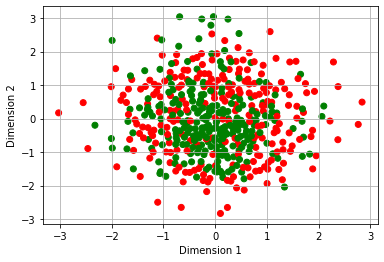

In [81]:
# visualize learnt representations
y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
x_ref = [Variable(t, volatile=True).data.numpy() for t in learner.train_set_x_tensor + learner.valid_set_x_tensor]

dist_tr_tr = np.empty([learner.n_train + learner.n_valid, learner.n_train + learner.n_valid], dtype = float);
for i in range(len(y_ref)):
    for j in range(len(y_ref)):
        X1 = x_ref[i]
        X2 = x_ref[j]

            #dist_tr_tr[i][j], _, _ = learner.distance_handler.dist_and_path(X1, X2)
        dist_tr_tr[i][j] = learner.distance_handler.dist(X1, X2)

            
dist_mat = dist_tr_tr*0.5 + dist_tr_tr.T*0.5
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
#mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
#manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
mds_fit = mds_model.fit(dist_mat)  
mds_coords = mds_model.fit_transform(dist_mat) 
    
color= ['red' if l == 0 else 'green' for l in y_ref]
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
plt.grid()
plt.axis('tight')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig(out_dir + distance_type + '_before.png', bbox_inches='tight')
    #plt.show()

~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


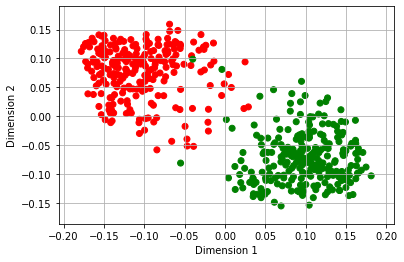

In [82]:
 
y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
x_ref = [learner.network(Variable(t, volatile=True)).data.numpy() for t in learner.train_set_x_tensor + learner.valid_set_x_tensor]

dist_tr_tr = np.empty([learner.n_train + learner.n_valid, learner.n_train + learner.n_valid], dtype = float);
for i in range(len(y_ref)):
    for j in range(len(y_ref)):
        X1 = x_ref[i]
        X2 = x_ref[j]
        
        dist_tr_tr[i][j] = learner.distance_handler.dist(X1, X2)

            
dist_mat = dist_tr_tr*0.5 + dist_tr_tr.T*0.5
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
#mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
#manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
mds_fit = mds_model.fit(dist_mat)  
mds_coords = mds_model.fit_transform(dist_mat) 
    
color= ['red' if l == 0 else 'green' for l in y_ref]
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
plt.grid()
plt.axis('tight')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.savefig(out_dir + distance_type + '_after.png', bbox_inches='tight')
    #plt.show()

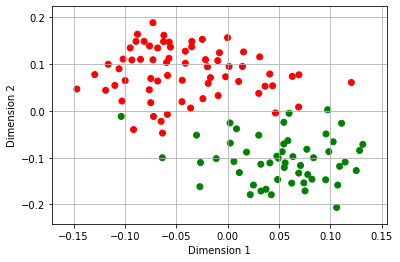

In [83]:
        

n_test = learner.n_test
y_eval=learner.test_set_y
dist_te_te = np.empty([n_test, n_test], dtype=object)
for i_te in range(learner.n_test):
    for i_tr in range(learner.n_test):
            
        X1 =learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_te])).detach().numpy() 
        X2 =learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_tr])).detach().numpy()
        dist_te_te[i_te][i_tr] = learner.distance_handler.dist(X1, X2)

dist_mat = dist_te_te*0.5 + dist_te_te.T*0.5
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
#mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
#manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
mds_fit = mds_model.fit(dist_mat)  
mds_coords = mds_model.fit_transform(dist_mat) 
color= ['red' if l == 0 else 'green' for l in y_eval]
plt.figure()
plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
plt.grid()
plt.axis('tight')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.savefig(out_dir + distance_type + '_test.png', bbox_inches='tight')
    

In [85]:
y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
x_ref = [learner.network(Variable(t, volatile=True)).data.numpy() for t in learner.train_set_x_tensor + learner.valid_set_x_tensor]


dist_te_tr = np.empty([learner.n_test, learner.n_train+learner.n_valid], dtype=object)
for i_te in range(learner.n_test):
    for i_tr in range(learner.n_train+learner.n_valid):
            
        X1 =learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_te])).detach().numpy() 
        X2 = x_ref[i_tr]
        #X2 =learner.network.forward(torch.from_numpy(learner.train_set_x_nparray[i_tr])).detach().numpy()
        dist_te_tr[i_te][i_tr] = learner.distance_handler.dist(X1, X2)

            
    
acc_mean = np.mean(test_accs_all, axis=0)
acc_std =  np.std(test_accs_all, axis=0)
    #save(dist_tr_tr, dist_te_tr, dist_te_te, acc_mean, acc_std)
    
mdic = {"distTrTr": dist_tr_tr, "distTeTr": dist_te_tr, "distTeTe": dist_te_te, 'acc_mean': acc_mean, 'acc_std' : acc_std  }

from scipy.io import savemat
savemat(out_dir + distance_type + "_res.mat", mdic)

~/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [86]:
from scipy.io import savemat
savemat(out_dir + distance_type + "_res.mat", mdic)

In [67]:
datafolder = '../new_data/ucieeg-new/'
datafile = datafolder + 'ucieeg-new.mat'
foldfile = datafolder + 'ucieeg-new-5folds.mat'
fold_id = 4
plot = True

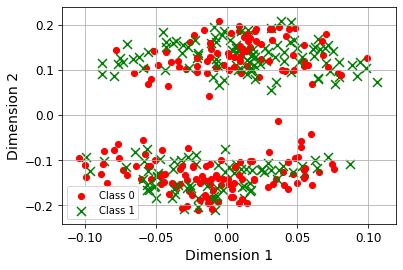

In [72]:
from scipy.io import loadmat
dat = loadmat(datafile)
y = np.squeeze(dat['y'])

fold_f = loadmat(foldfile)
I = fold_f['folds']

    #neig = loadmat(neighbor_file)
    #neig['neighborTrTe']

#trI = np.where(I != fold_id + 1)[1]
#testI = np.where(I == fold_id hg+ 1)[1]

testI = I == fold_id+1
I_valid = I == ((fold_id+1)%5 + 1)
trI = np.logical_not(np.logical_or(testI, I_valid))

y_eval = [y[i] for i in testI]
y_true = [y[i] for i in trI + I_valid][0]

if plot == True:
    dist_mat = dist_tr_tr*0.5 + dist_tr_tr.T*0.5
    # dist_mat = dist_tr_tr
    mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
    #mds_model = manifold.TSNE(n_components = 3, random_state = 0,metric = 'precomputed')
    #manifold.TSNE(n_components=2, random_state=0, metric='precomputed')
    mds_fit = mds_model.fit(dist_mat)  
    mds_coords = mds_model.fit_transform(dist_mat) 
    color= ['red' if l == 0 else 'green' for l in y_true]
    marks = ['.' if l == 0 else "x" for l in y_true]

    
    ax = plt.axes()
    
    for i in range(0,mds_coords.shape[0]):
        if marks[i] == '.':
            cl0 = ax.scatter(mds_coords[i,0],mds_coords[i,1], color=color[i] , marker=marks[i],  s=150)
        else:
            cl1 = ax.scatter(mds_coords[i,0],mds_coords[i,1], color=color[i] , marker=marks[i],  s=80)
      #  plt.scatter(mds_coords[i,0],mds_coords[i,1], color=color[i] , marker=marks[i],  s=20)
    #plt.scatter(mds_coords[:,0],mds_coords[:,1], color=color)
    #ax = plt.axes(projection ="3d")
    #ax.scatter3D(mds_coords[:,0],mds_coords[:,1], mds_coords[:,2], color=color, marker=marker)
    ax.grid()
    ax.axis('tight')
    ax.set_xlabel('Dimension 1', fontsize=14)
    ax.set_ylabel('Dimension 2', fontsize=14) 
    ax.tick_params(axis='both', which='major', labelsize=12,  length=4)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=4)
    ax.legend((cl0, cl1), ['Class 0', 'Class 1'], loc='lower left')
 

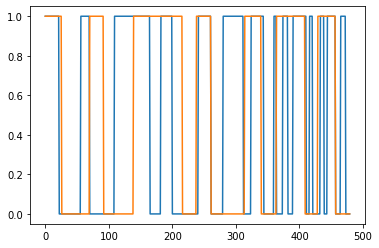

In [73]:
y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
plt.plot(y_ref)
plt.plot(y_true)

In [71]:
[2, 3, 5] + [ 1, 4]

[2, 3, 5, 1, 4]

In [47]:
len(trI)


600

In [9]:
from scipy.io import savemat
mdic = {"distTrTr": distTrTr, "distTeTr": distTeTr, 'acc_mean': acc_mean, 'acc_std' : acc_std, 'acc': test_acc_all }
out_dir = '../python_pytorch/results/ucieeg-new/run_jupyter/'

savemat(out_dir + distance_type + "_res.mat", mdic)

5

In [11]:
out_dir = '../python_pytorch/results/ucieeg-new/run_jupyter/'

In [12]:
out_dir

'../python_pytorch/results/ucieeg-new/run_jupyter/'

In [87]:
l =  []
l.append(dist_tr_tr)
l.append(dist_tr_tr)


In [93]:
savemat(out_dir + 'test.mat', {'distTrTr':l})

In [94]:
res = loadmat(out_dir + 'test.mat')

(2, 480, 480)

In [ ]:
distTrTr = []
distTeTr = []

y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
x_ref = [learner.network(Variable(t, volatile=True)).data.numpy() for t in learner.train_set_x_tensor + learner.valid_set_x_tensor]

dist_tr_tr = np.empty([learner.n_train + learner.n_valid, learner.n_train + learner.n_valid], dtype = float);
for i in range(len(y_ref)):
    for j in range(len(y_ref)):
        X1 = x_ref[i]
        X2 = x_ref[j]
        
        dist_tr_tr[i][j] = learner.distance_handler.dist(X1, X2)
        
distTrTr.append(dist_tr_tr)

#y_ref = np.concatenate((learner.train_set_y, learner.valid_set_y))
#x_ref = [learner.network(Variable(t, volatile=True)).data.numpy() for t in learner.train_set_x_tensor + learner.valid_set_x_tensor]



dist_te_tr = np.empty([learner.n_test, learner.n_train+learner.n_valid], dtype=object)
for i_te in range(learner.n_test):
    for i_tr in range(learner.n_train+learner.n_valid):
            
        X1 =learner.network.forward(torch.from_numpy(learner.test_set_x_nparray[i_te])).detach().numpy() 
        X2 = x_ref[i_tr]
        
        dist_te_tr[i_te][i_tr] = learner.distance_handler.dist(X1, X2)
        
distTeTr.append(dist_te_tr)


    
acc_mean = np.mean(test_accs_all, axis=0)
acc_std =  np.std(test_accs_all, axis=0)
    #save(dist_tr_tr, dist_te_tr, dist_te_te, acc_mean, acc_std)
    
mdic = {"distTrTr": distTrTr, "distTeTr": distTeTr, 'acc_mean': acc_mean, 'acc_std' : acc_std, 'acc': test_acc_all }

        
